In [ ]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("prathmeshzade/iiit5k-words")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iiit5k-words


In [ ]:
import os
import numpy as np
import pandas as pd
import keras
f = os.listdir(path)

In [ ]:
path

'/kaggle/input/iiit5k-words'

In [ ]:
import torch

In [ ]:
t = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
tar_to_idx = {}
idx_to_tar = {}
for i, j in enumerate(t):
    tar_to_idx[j] = i
    idx_to_tar[i] = j

In [ ]:
maxlen = 0
d = pd.read_csv(path + '/traindata.csv')


In [ ]:
for i in d.iloc[:,1]:
    if maxlen <len(i):
        maxlen = len(i)
print(maxlen)

22


In [ ]:
from PIL import Image

In [ ]:
def preprocess(target_size=(64,32), maxlen=36):
    images = torch.empty((d.shape[0], 3, target_size[1], target_size[0]), dtype=torch.float32) # Initialize with correct shape
    labels = torch.empty((d.shape[0], maxlen), dtype=torch.int32)
    label_lengths = []
    for i in range(d.shape[0]):
        td = Image.open(path+'/IIIT5K-Word_V3.0' + '/IIIT5K/' + d.iloc[i, 0])

            # image is wider than target
        td = td.resize((target_size[0], target_size[1]))
            # image is taller than target


        td = keras.preprocessing.image.img_to_array(td)
        td = torch.tensor(td).permute(2,0,1) / 255. # Permute dimensions to (Channels, Height, Width)


        images[i] = td
        temp = []
        for a in d.iloc[i, 1]:
            temp.append(tar_to_idx[a]+1)
        label_lengths.append(len(temp))
        if len(temp) <maxlen:
            temp.extend([0]*(maxlen-len(temp)))
        labels[i] = torch.tensor(temp)


    return images, labels, label_lengths

In [ ]:
def label_to_text(label):
    s= ''

    l = label.numpy()
    for i in l:
        if i==0:
            continue
        s+=idx_to_tar[int(i-1)]
    return s

In [ ]:
images,labels, label_lengths = preprocess()
dataset = torch.utils.data.TensorDataset(images, labels, torch.tensor(label_lengths))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16) # Reduced batch size

In [ ]:
import matplotlib.pyplot as plt
import random

[ 9 14  4  9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]
INDIA


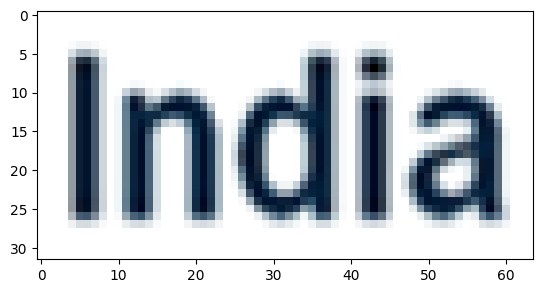

In [ ]:
i = random.randint(0,2000)
plt.imshow(images[i].permute(1,2,0))
print(label_to_text(labels[i]))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2,1), (2,1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(), nn.MaxPool2d((2,1), (2,1)),
            nn.Conv2d(512, 512, 2, 1, 0), nn.ReLU()
        )
        # RNN
        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh*2, nh, bidirectional=True)

        self.embedding = nn.Linear(nh*2, nclass)

    def forward(self, x):
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        assert h == 1, "CNN output height must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        rnn_out1, _ = self.rnn1(conv)
        rnn_out2, _ = self.rnn2(rnn_out1)

        output = self.embedding(rnn_out2)
        return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_crnn(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels, label_lengths) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # outputs shape: [seq_len, batch, nclass]

            # Compute input lengths for CTC (all sequences have the same length here)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs.log_softmax(2), labels, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 9:  # print every 10 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')


In [ ]:
model = CRNN(imgH=32, nc=3, nclass=37, nh=256)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
train_crnn(model, dataloader, criterion, optimizer, device=device, num_epochs=100)


Epoch [1/100], Step [10/125], Loss: 10.1535
Epoch [1/100], Step [20/125], Loss: 5.4580
Epoch [1/100], Step [30/125], Loss: 4.2115
Epoch [1/100], Step [40/125], Loss: 4.0922
Epoch [1/100], Step [50/125], Loss: 4.0989
Epoch [1/100], Step [60/125], Loss: 3.8365
Epoch [1/100], Step [70/125], Loss: 3.7984
Epoch [1/100], Step [80/125], Loss: 3.7060
Epoch [1/100], Step [90/125], Loss: 3.6351
Epoch [1/100], Step [100/125], Loss: 3.6188
Epoch [1/100], Step [110/125], Loss: 3.5903
Epoch [1/100], Step [120/125], Loss: 3.7545
Epoch [2/100], Step [10/125], Loss: 3.8144
Epoch [2/100], Step [20/125], Loss: 3.9981
Epoch [2/100], Step [30/125], Loss: 3.9223
Epoch [2/100], Step [40/125], Loss: 4.0527
Epoch [2/100], Step [50/125], Loss: 4.0378
Epoch [2/100], Step [60/125], Loss: 3.7527
Epoch [2/100], Step [70/125], Loss: 3.7146
Epoch [2/100], Step [80/125], Loss: 3.6342
Epoch [2/100], Step [90/125], Loss: 3.5099
Epoch [2/100], Step [100/125], Loss: 3.5149
Epoch [2/100], Step [110/125], Loss: 3.4993
Epoch

In [ ]:
def predict(im): # predict only one image at a time
    im = im.unsqueeze(0)
    with torch.no_grad():

        im = im.to(device)

        out = model(im)
        out = out.softmax(2)
        out= out.argmax(2)
        out= out.permute(1,0)
        return out.cpu()[0]

Testing the Model

Predicted : WARR
real : WAR


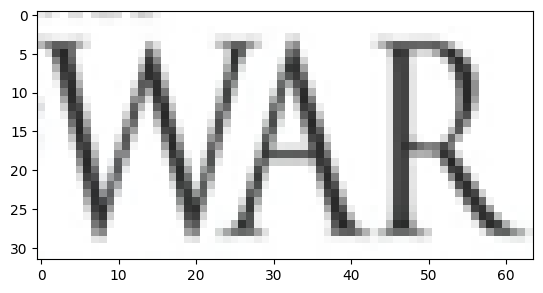

In [ ]:
i = random.randint(0, 2000)
out = predict(images[i])
print("Predicted :", label_to_text(out))
print("real :", label_to_text(labels[i]))
plt.imshow(images[i].permute(1,2,0))